## LSTM

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [2]:
original = pd.read_csv('merged_data.csv')

original

,Date,Open,High,Low,Close,Adj Close,Volume,Prev_Volume,Prev_Close,Weekday,...,FTSE 100,DAX,S&P500,Hang Seng Index,NASDAQ,Nikkei 225,Market Volatility,CPI,USD Index,Retail Sales
0,2014-01-06,40.480000,40.590000,40.160000,40.270000,30.012405,11036300.0,10403400.0,40.459999,1.0,...,6730.700195,9428.000000,1826.770020,22684.150391,4113.680176,15908.879883,13.550000,233.916,93.9109,373327.0
1,2014-01-07,40.480000,40.720001,40.290001,40.389999,30.101828,11872300.0,11036300.0,40.270000,2.0,...,6755.500000,9506.200195,1837.880005,22712.779297,4153.180176,15814.370117,12.920000,233.916,94.0398,373327.0
2,2014-01-08,40.439999,40.439999,39.830002,39.939999,29.766455,15339600.0,11872300.0,40.389999,3.0,...,6721.799805,9497.839844,1837.489990,22996.589844,4165.609863,16121.450195,12.870000,233.916,94.2181,373327.0
3,2014-01-09,39.950001,40.000000,39.520000,39.730000,29.609943,14070200.0,15339600.0,39.939999,4.0,...,6691.299805,9421.610352,1838.130005,22787.330078,4156.189941,15880.330078,12.890000,233.916,94.3299,373327.0
4,2014-01-10,39.959999,40.290001,39.900002,40.130001,29.908060,13290000.0,14070200.0,39.730000,5.0,...,6739.899902,9473.240234,1842.369995,22846.250000,4174.669922,15912.059570,12.140000,233.916,94.0045,373327.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965,2022-12-22,63.419998,63.590000,62.650002,63.340000,62.857849,9666700.0,10411300.0,63.799999,4.0,...,7469.299805,13914.070312,3822.389893,19679.220703,10476.120117,26507.869141,21.969999,296.797,122.2105,589030.0
1966,2022-12-23,63.500000,63.869999,63.200001,63.820000,63.334194,6463300.0,9666700.0,63.340000,5.0,...,7473.000000,13940.929688,3844.820068,19593.060547,10497.860352,26235.250000,20.870001,296.797,121.9579,589030.0
1967,2022-12-28,64.459999,64.650002,63.490002,63.570000,63.086098,7159400.0,7320700.0,64.209999,3.0,...,7497.200195,13925.599609,3783.219971,19898.910156,10213.290039,26340.500000,22.139999,296.797,121.9983,589030.0
1968,2022-12-29,63.799999,64.150002,63.700001,63.950001,63.463207,7169300.0,7159400.0,63.570000,4.0,...,7512.700195,14071.719727,3849.280029,19741.140625,10478.089844,26093.669922,21.440001,296.797,121.6556,589030.0


In [3]:
# Normalise using MinMax scaler
from sklearn.preprocessing import MinMaxScaler

# only select the specified columns
#df = original.loc[:, ['Close']].copy()
df = original.loc[:, ['Open','High','Low','Prev_Close','Volume','100SMA','20SMA','MNST','Retail Sales',
                      'Raw Sugar Futures','CPI','S&P500','GDP','Market Volatility','FTSE 100','SHEL','Gold',
                      'Close']].copy()

num_features = df.shape[1]-1

# Create an instance of MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the dataframe using fit_transform method of the scaler object
# and convert the resulting array back into a pandas datafram
data_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

data_df # scaled version of 'df'

,Open,High,Low,Prev_Close,Volume,100SMA,20SMA,MNST,Retail Sales,Raw Sugar Futures,CPI,S&P500,GDP,Market Volatility,FTSE 100,SHEL,Gold,Close
0,0.114228,0.103437,0.132088,0.115424,0.123980,0.004970,0.082477,0.012819,0.000000,0.470548,0.003250,0.024698,0.0,0.058936,0.621507,0.791707,0.186869,0.108897
1,0.114228,0.107817,0.136503,0.108897,0.136871,0.005225,0.083287,0.017963,0.000000,0.469178,0.003250,0.028351,0.0,0.050361,0.630381,0.801626,0.178475,0.113020
2,0.112892,0.098383,0.120883,0.113020,0.190338,0.005578,0.083158,0.020575,0.000000,0.447260,0.003250,0.028222,0.0,0.049680,0.618322,0.793333,0.174378,0.097561
3,0.096526,0.083558,0.110357,0.097561,0.170763,0.005927,0.082311,0.017199,0.000000,0.429452,0.003250,0.028433,0.0,0.049952,0.607407,0.797236,0.178375,0.090347
4,0.096860,0.093329,0.123260,0.090347,0.158732,0.006206,0.082090,0.026321,0.000000,0.435616,0.003250,0.029827,0.0,0.039744,0.624799,0.819187,0.195763,0.104088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965,0.880427,0.878369,0.895756,0.917211,0.102860,0.892273,0.938138,0.961061,0.940883,0.800000,0.981106,0.680742,1.0,0.173540,0.885811,0.571057,0.735685,0.901408
1966,0.883100,0.887803,0.914431,0.901408,0.053462,0.892150,0.939446,0.966486,0.940883,0.806164,0.981106,0.688116,1.0,0.158568,0.887135,0.587967,0.744579,0.917898
1967,0.915164,0.914084,0.924278,0.931295,0.064196,0.892330,0.944309,0.967209,0.940883,0.750000,0.981106,0.667865,1.0,0.175854,0.895795,0.568130,0.756570,0.909310
1968,0.893120,0.897237,0.931409,0.909310,0.064349,0.892408,0.946317,0.975648,0.940883,0.758904,0.981106,0.689582,1.0,0.166326,0.901342,0.569919,0.768162,0.922364


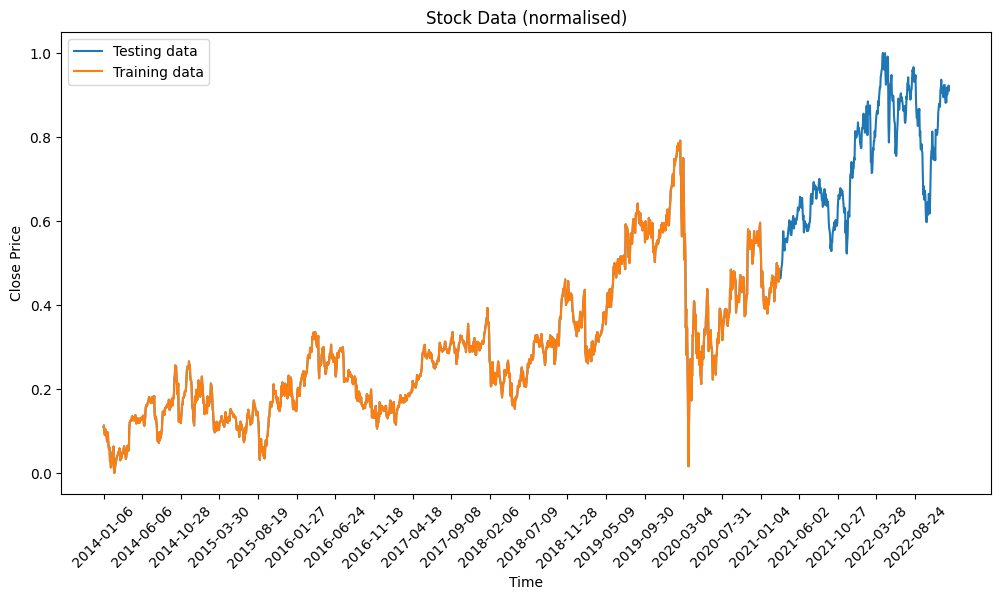

In [4]:
import matplotlib.pyplot as plt

# Split the data into 3 sections: train, validation, test
# for the hyperparameter tuning stage, train, validation are used
# for the final testing stage, train+validation is used as train data and test for testing

num_samples = len(data_df)
num_test = int(0.2*num_samples)
num_train = num_samples - num_test 

# convert the nomorlised price ('data' here) into DataFrame for plotting
df_plot = pd.DataFrame(data_df, columns=['Close'])

# Plot the dataframe

# df.plot(figsize=(10, 5))      # plot all columns
plt.figure(figsize = (12,6))
plt.plot(df_plot['Close'], label='Testing data')
plt.plot(df_plot['Close'][:num_train], label='Training data') 
plt.xticks(range(0, original.shape[0],3*30), original['Date'].loc[::3*30],rotation=45)

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Stock Data (normalised)')
plt.legend()

plt.show()

In [5]:
multi_step = 5
seq_len = 20

# create input sequences
input_seq = []
for index in range(len(data_df) - seq_len - multi_step + 1): 
    if num_features == 0:
        input_seq.append(data_df.iloc[index:index+seq_len])
    else:
        input_seq.append(data_df.iloc[index:index+seq_len, :-1])


# create output sequences
output_seq = []
for i in range(seq_len, len(data_df) - multi_step + 1):
    output_seq_i = []
    for j in range(multi_step):
        output_seq_i.append(data_df.iloc[i+j,-1])
    output_seq.append(output_seq_i)

# convert to numpy arrays and reshape
if num_features == 0:
    x = np.array(input_seq).reshape(-1, seq_len, 1)
else:
    x = np.array(input_seq).reshape(-1, seq_len, num_features)
y = np.array(output_seq).reshape(-1, multi_step)


# for the hyperparameter tuning stage, train, validation are used

train_set_size = int(0.8*num_train)
test_set_size = num_train - train_set_size
    
x_train = x[:train_set_size]
y_train = y[:train_set_size]
    
x_test = x[train_set_size:]
y_test = y[train_set_size:]

print(train_set_size)
print(x.shape)
print(y.shape)
print('x_train.shape = ',x_train.shape) 
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)
# %whos

1260
(1946, 20, 17)
(1946, 5)
x_train.shape =  (1260, 20, 17)
y_train.shape =  (1260, 5)
x_test.shape =  (686, 20, 17)
y_test.shape =  (686, 5)


In [6]:
# convert to tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_train_true = x_train.clone() # clone() copies the content, otherwise it only copies the reference
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_train_true = torch.from_numpy(y_train).type(torch.Tensor)
y_train_true_copy = y_train_true.clone() # keep a copy of the true y_train_labels for plotting use
y_test_true = torch.from_numpy(y_test).type(torch.Tensor)

In [7]:
if num_features == 0:
    input_dim = 1 
else:
    input_dim = num_features
hidden_dim = 32 # number of units in each LSTM layer
num_layers = 2  # number of LSTM layers
output_dim = multi_step
num_epochs = 15
lr = 0.01
dropout_prob = 0.0
batch_size = 32

In [8]:
class LSTM(nn.Module):    
    def __init__(self, input_dim, hidden_dim, dropout_prob, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        # Define the dimensions of input, hidden, and output layers
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_prob)
        
        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        
        # Pass the input through the LSTM layer
        lstm_out, _ = self.lstm(x)
        
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        
        # Pass the last hidden state of the LSTM layer through the output layer
        y_pred = self.linear(lstm_out[:, -1, :])
        
        return y_pred

## Hyperparameter tuning

In [9]:
from sklearn.model_selection import ParameterGrid
import time

start_time = time.time()

# Define hyperparameters to tune
param_grid = {
    'num_layers': [2,3],
    'hidden_dim': [32],
    'batch_size': [32],
    'dropout_prob': [0.0],
    'lr': [0.005,0.01,0.05],
    'num_epochs': [10, 15]
}

# Initialize best hyperparameters and best validation loss
best_params = None
best_val_loss = float('inf')

# Loop through all hyperparameter combinations
for params in ParameterGrid(param_grid):
    print(params)
    
    model_LSTM = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, dropout_prob=dropout_prob, num_layers=num_layers, output_dim=output_dim)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model_LSTM.parameters(), lr=lr)
    
    # Training loop
    for epoch in range(num_epochs):
        # Shuffle the training data at the start of each epoch
        indices = torch.randperm(x_train.shape[0])
        x_train = x_train[indices]
        y_train_true = y_train_true[indices]

        # Iterate over mini-batches
        for i in range(0, x_train.shape[0], batch_size):
            # Get the current mini-batch
            x_batch = x_train[i:i+batch_size]
            y_batch_true = y_train_true[i:i+batch_size]

            # Forward pass
            y_batch_pred = model_LSTM(x_batch)

            # Compute the loss
            loss = criterion(y_batch_pred, y_batch_true)

            # Backward pass
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

    # testing error
    y_test_pred = model_LSTM(x_test).detach().numpy()
    rmse_test = np.sqrt(np.mean(np.square(np.array(y_test_true) - y_test_pred)))

    # Check if this is the best model so far
    if rmse_test < best_val_loss:
        best_val_loss = rmse_test
        best_params = params
        print(f'Epoch {epoch+1}: rmse_val={rmse_test:.4f} (***BEST SO FAR***)')
    else:
        print(f'Epoch {epoch+1}: rmse_val={rmse_test:.4f}')    

        
# Print the best hyperparameters and best validation loss
print()
print(f'Best params: {best_params}')
print(f'Best val_loss: {best_val_loss:.4f}')

print()
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

{'batch_size': 32, 'dropout_prob': 0.0, 'hidden_dim': 32, 'lr': 0.005, 'num_epochs': 10, 'num_layers': 2}
Epoch 15: rmse_val=0.0676 (***BEST SO FAR***)
{'batch_size': 32, 'dropout_prob': 0.0, 'hidden_dim': 32, 'lr': 0.005, 'num_epochs': 10, 'num_layers': 3}
Epoch 15: rmse_val=0.0860
{'batch_size': 32, 'dropout_prob': 0.0, 'hidden_dim': 32, 'lr': 0.005, 'num_epochs': 15, 'num_layers': 2}
Epoch 15: rmse_val=0.0918
{'batch_size': 32, 'dropout_prob': 0.0, 'hidden_dim': 32, 'lr': 0.005, 'num_epochs': 15, 'num_layers': 3}
Epoch 15: rmse_val=0.0864
{'batch_size': 32, 'dropout_prob': 0.0, 'hidden_dim': 32, 'lr': 0.01, 'num_epochs': 10, 'num_layers': 2}
Epoch 15: rmse_val=0.0683
{'batch_size': 32, 'dropout_prob': 0.0, 'hidden_dim': 32, 'lr': 0.01, 'num_epochs': 10, 'num_layers': 3}
Epoch 15: rmse_val=0.0722
{'batch_size': 32, 'dropout_prob': 0.0, 'hidden_dim': 32, 'lr': 0.01, 'num_epochs': 15, 'num_layers': 2}
Epoch 15: rmse_val=0.0752
{'batch_size': 32, 'dropout_prob': 0.0, 'hidden_dim': 32, '

In [10]:
# Input the best hyperparamters
batch_size = best_params['batch_size']
hidden_dim = best_params['hidden_dim']
dropout_prob = best_params['dropout_prob']
lr = best_params['lr']
num_epochs = best_params['num_epochs']
num_layers = best_params['num_layers']

In [11]:
# testing after hyperparameter tuning using the reserved test data

train_set_size = num_train
test_set_size = num_test

x_train = x[:train_set_size]
y_train = y[:train_set_size]
    
x_test = x[train_set_size:]
y_test = y[train_set_size:]

# convert to tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_train_true = x_train.clone() # clone() copies the content, otherwise it only copies the reference
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_train_true = torch.from_numpy(y_train).type(torch.Tensor)
y_train_true_copy = y_train_true.clone() # keep a copy of the true y_train_labels for plotting use
y_test_true = torch.from_numpy(y_test).type(torch.Tensor)

In [12]:
model_LSTM = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, dropout_prob=dropout_prob, num_layers=num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_LSTM.parameters(), lr=lr)

In [13]:
# Training loop
for epoch in range(num_epochs):
    # Shuffle the training data at the start of each epoch
    indices = torch.randperm(x_train.shape[0])
    x_train = x_train[indices]
    y_train_true = y_train_true[indices]

    # Iterate over mini-batches
    for i in range(0, x_train.shape[0], batch_size):
        # Get the current mini-batch
        x_batch = x_train[i:i+batch_size]
        y_batch_true = y_train_true[i:i+batch_size]

        # Forward pass
        y_batch_pred = model_LSTM(x_batch)

        # Compute the loss
        loss = criterion(y_batch_pred, y_batch_true)

        # Backward pass
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    # Print the loss for the epoch
    print("Epoch ", epoch+1, "Training MSE: ", loss.item())

Epoch  1 Training MSE:  0.0013943699887022376
Epoch  2 Training MSE:  0.004597231280058622
Epoch  3 Training MSE:  0.0031450972892344
Epoch  4 Training MSE:  0.00110619084443897
Epoch  5 Training MSE:  0.0015732988249510527
Epoch  6 Training MSE:  0.002370876958593726
Epoch  7 Training MSE:  0.001364966039545834
Epoch  8 Training MSE:  0.0008450443856418133
Epoch  9 Training MSE:  0.001078749424777925
Epoch  10 Training MSE:  0.00071594153996557


Train loss (RMSE): 0.039 RMSE
Test loss (RMSE): 0.065 RMSE


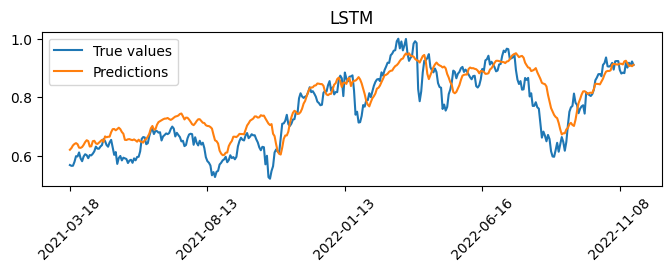

In [14]:
# make predictions for the furthest day in the future
y_test_pred = model_LSTM(x_test).detach().numpy()
rmse_test = np.sqrt(np.mean(np.square(np.array(y_test_true[:,-1]) - y_test_pred[:,-1])))

y_train_pred = model_LSTM(x_train_true).detach().numpy()
rmse_train = np.sqrt(np.mean(np.square(np.array(y_train_true_copy[:,-1]) - y_train_pred[:,-1])))

# calculate root mean squared error
print('Train loss (RMSE): %.3f RMSE' % (rmse_train))
print('Test loss (RMSE): %.3f RMSE' % (rmse_test))

# set figure size
plt.figure(figsize=(8, 2))

plt.plot(y_test_true[:,-1], label='True values')
plt.plot(y_test_pred[:,-1], label='Predictions')

plot_x_test = original.tail(num_samples-num_train)
plt.xticks(range(0, plot_x_test.shape[0],3*30), plot_x_test['Date'].loc[::3*30],rotation=45)
plt.title("LSTM")
plt.legend()

plt.show()

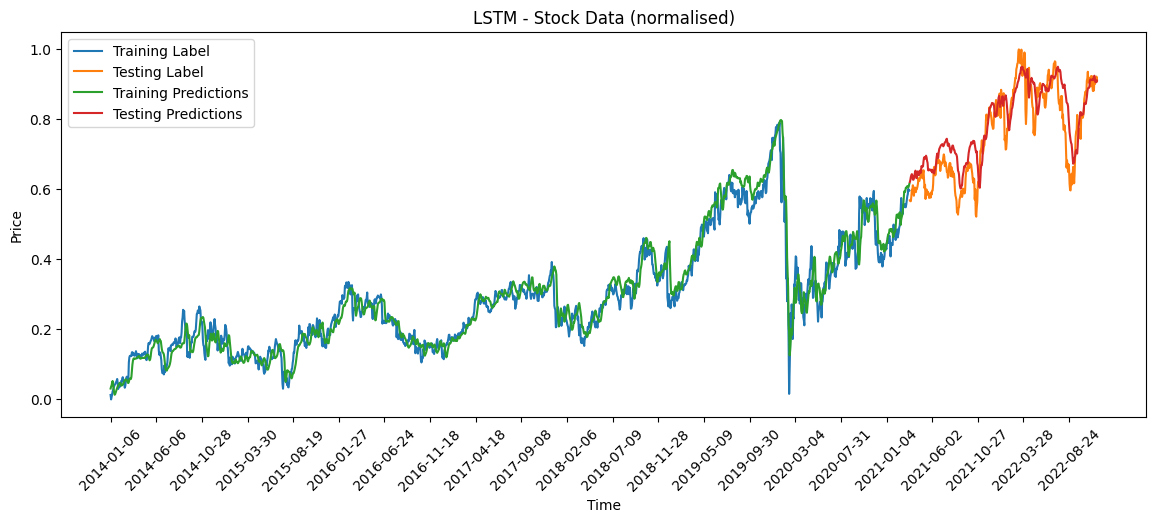

In [15]:
# Plot both the true and prediction data

# Combine the training and testing labels into a single dataframe
train_labels_df = pd.DataFrame(y_train_true_copy[:, -1], columns=['Training Label'])
test_labels_df = pd.DataFrame(y_test_true[:, -1], columns=['Testing Label'])
labels_df = pd.concat([train_labels_df, test_labels_df], axis=0, ignore_index=True)

# add the predictions to the dataframe
train_pred_df = pd.DataFrame(y_train_pred[:, -1], columns=['Training Predictions'])
test_pred_df = pd.DataFrame(y_test_pred[:,-1], columns=['Testing Predictions'])
pred_df = pd.concat([train_pred_df, test_pred_df], axis=0, ignore_index=True)
#print(predictions_df.index)

# generate the final dataframe
labels_df = pd.concat([labels_df, pred_df], axis=1)

# Plot the combined data
ax = labels_df.plot(figsize=(14, 5))
ax.set_xlabel('Time')
ax.set_ylabel('Price')
plt.title('LSTM - Stock Data (normalised)')
plt.xticks(range(0, original.shape[0],3*30), original['Date'].loc[::3*30],rotation=45)
ax.legend()
plt.show()